In [9]:
# | echo: false
# | output: false
# | warning: false

from datetime import datetime
from os import path
from os.path import join
from os import cpu_count
from typing import List, Union

import decoupler as dc
import gseapy as gs
import pandas as pd
import panel as pn
import scanpy as sc
import tomlkit


pn.extension("tabulator")
sc.settings.n_jobs = int( 0.8 * cpu_count())


In [2]:
# | echo: true
# | output: false
# | warning: false

CLUSTERING_COL: str = "leiden_1.0"
CONDIITION: Union[str, None] = None
SUBSET: Union[str, List, None] = None

# Check options from gseapy.show_resouces()
ENRICHMENT_DBS: list[str] = []

In [11]:
# | echo: false
# | output: false
# | warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [ ]:
# | output: false
# | warning: false


# Directories
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
DIR_samples = config["basic"]["DIR_SAMPLES"]

# Basic information
ORGANISM: str = config["basic"]["ORGANISM"]
NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]

if CLUSTERING_COL == "":
    CLUSTERING_COL = config["clustering"]["CLUSTERING_COL"]
elif CLUSTERING_COL == "":
    raise ValueError(
        "No clustering column found. please provide a key for cell grouping"
    )

In [17]:
# | echo: false
# | output: false
# | warning: false

#adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
adata = sc.read_h5ad(path.join("../save", "adata.h5ad"))
adata.X = adata.layers[NORMALIZATION_METHOD].copy()

In [6]:
# | echo: false
# | output: false
# | warning: false

sc.tl.rank_genes_groups(
    adata,
    groupby=CLUSTERING_COL,
    mask_var=SUBSET,
    layer=NORMALIZATION_METHOD,
    method="wilcoxon",
    pts=True,
)
sc.tl.filter_rank_genes_groups(adata)

In [7]:
# | echo: false
# | output: false
# | warning: false

cell_types = adata.obs[CLUSTERING_COL].unique().tolist()
de_df = {}
for c_type in cell_types:
    de_df[c_type] = sc.get.rank_genes_groups_df(adata, group=c_type).sort_values(
        by="logfoldchanges", ascending=False
    )

In [8]:
# # | echo: false
# # | output: false
# # | warning: false

# writer = pd.ExcelWriter(
#     join(DIR_SAVE, datetime.strftime(datetime.now(), "%Y%m%d") + "_DE_results.xlsx"),
#     engine="openpyxl",
# )
# for df_name, df in de_df.items():
#     df.to_excel(writer, sheet_name=df_name)
# writer.close()

In [9]:
# | echo: false
# | output: false
# | warning: false

cell_types = adata.obs[CLUSTERING_COL].unique().tolist()
de_df = {}
for c_type in cell_types:
    de_df[c_type] = sc.get.rank_genes_groups_df(
        adata, group=c_type, pval_cutoff=0.05
    ).sort_values(by="logfoldchanges", ascending=False)

In [10]:
# | echo: false
# | warning: false

widget_ls = []
for index, key in enumerate(de_df.keys()):
    widget_ls.append((key, pn.widgets.DataFrame(de_df[key])))

pn.Tabs(*widget_ls)


BokehModel(combine_events=True, render_bundle={'docs_json': {'deefb662-3ff3-4956-a22d-25f1d0869018': {'version…

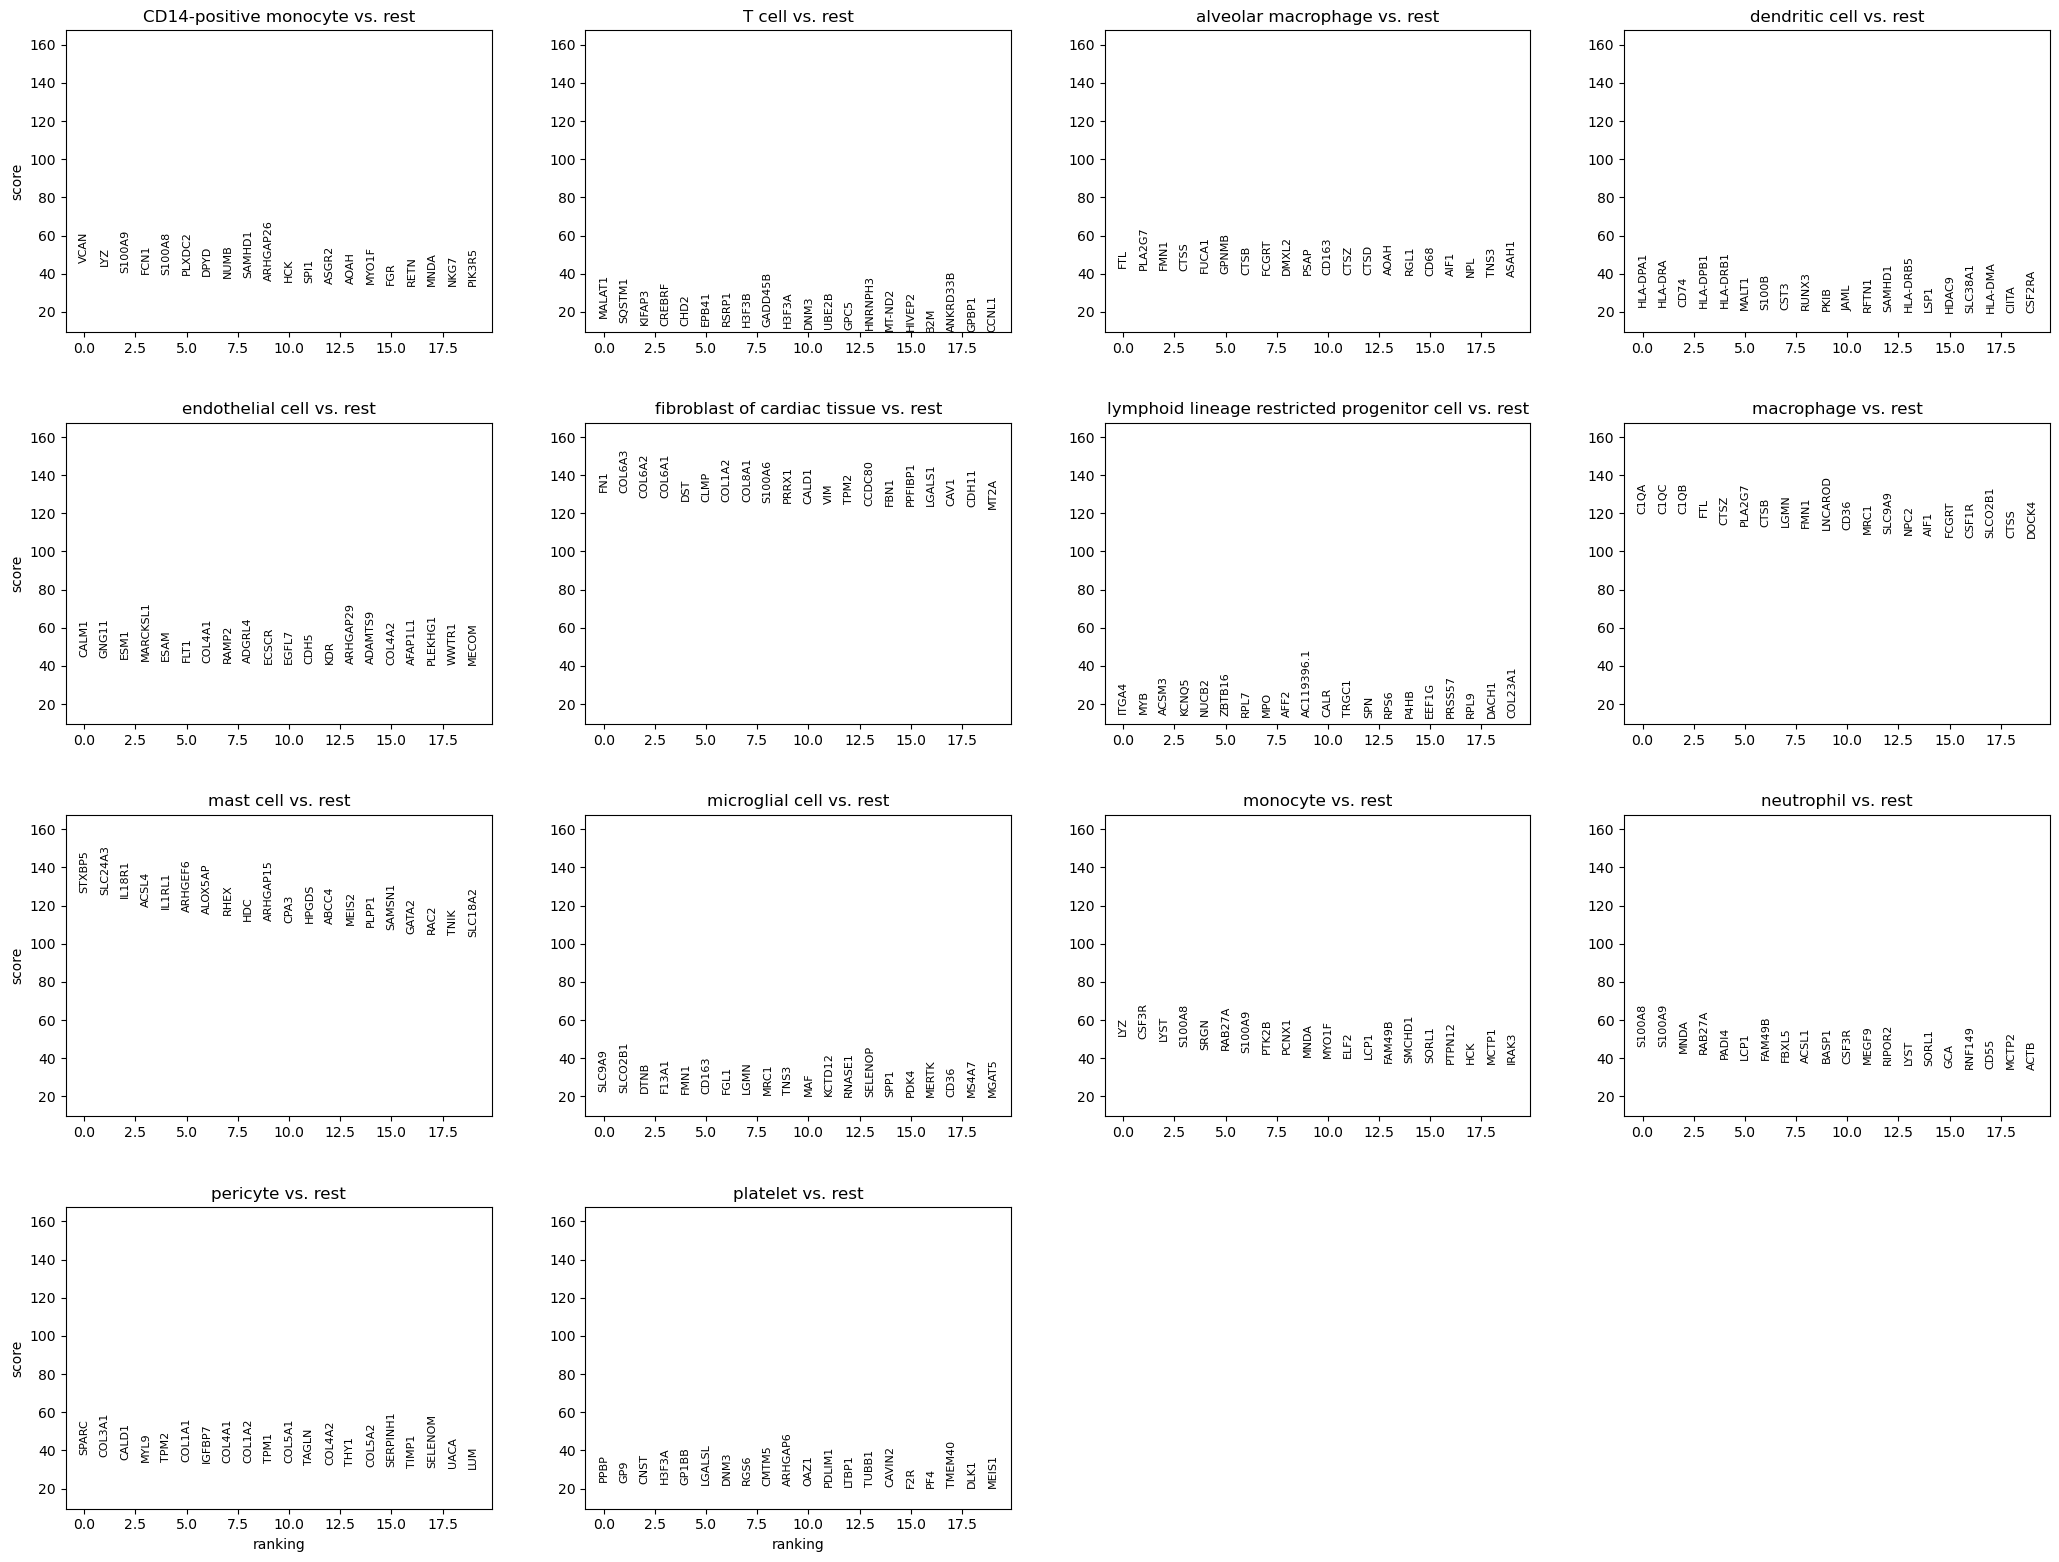

In [11]:
# | echo: false
# | warning: false
# | fig-width: 4
# | fig-height: 4


sc.pl.rank_genes_groups(adata)

## Dot plot

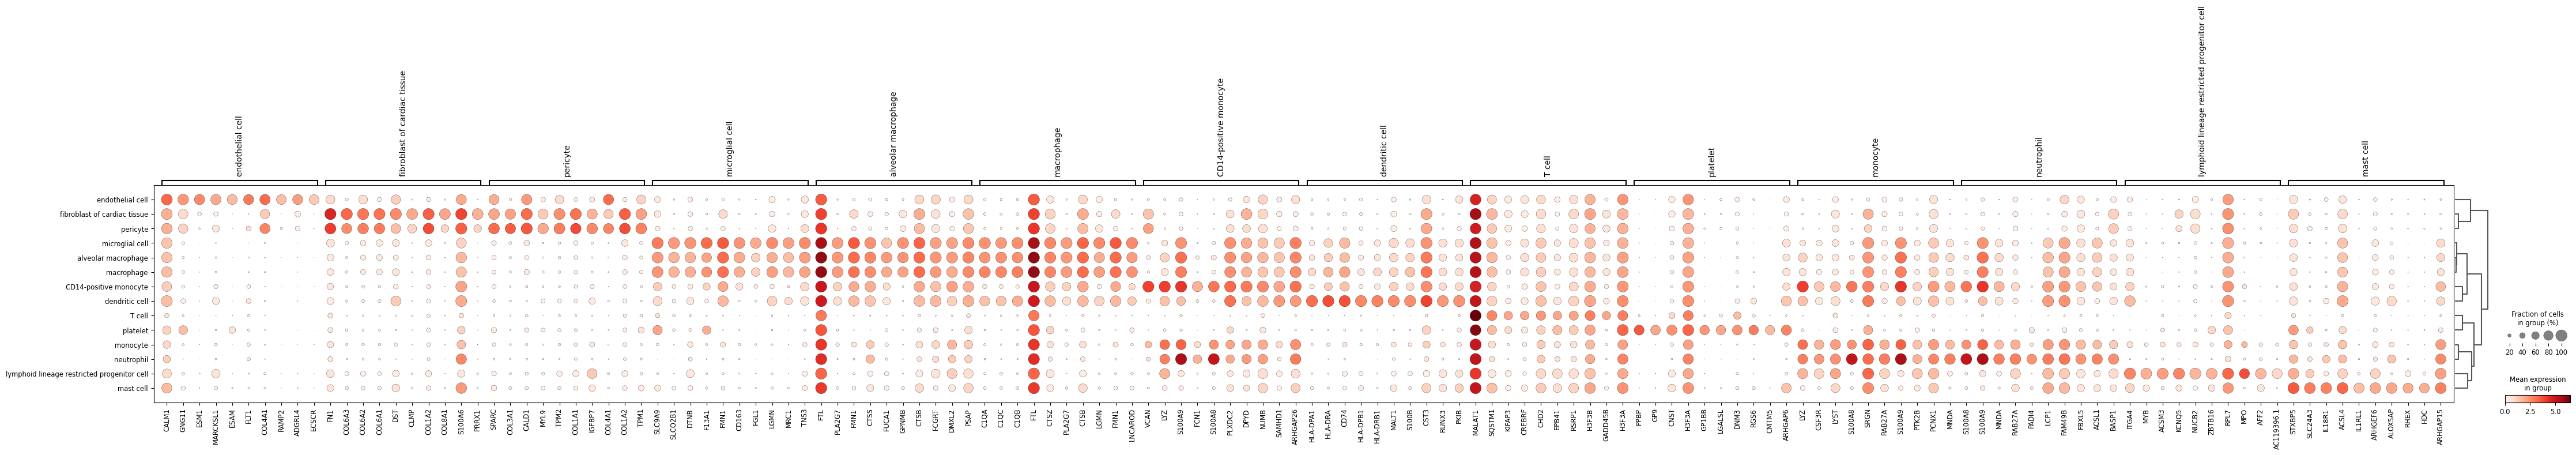

In [12]:
# | echo: false
# | warning: false
#| fig-width: 50%


sc.pl.rank_genes_groups_dotplot(adata)

## Heatmap

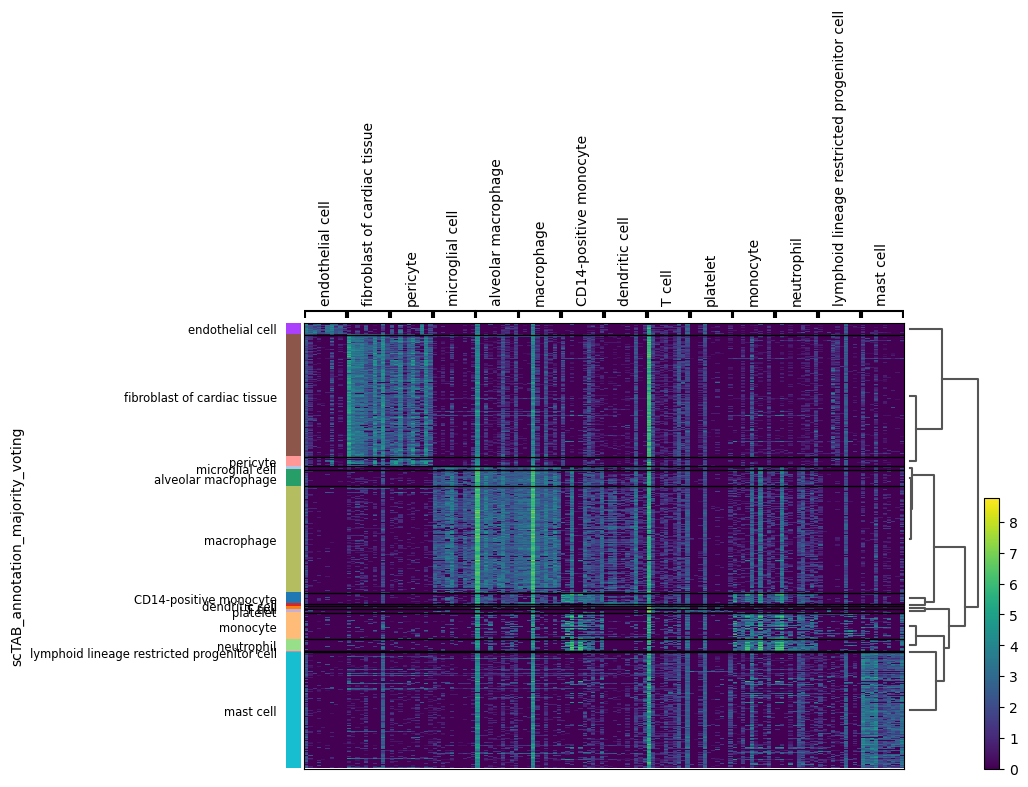

In [13]:
# | echo: false
# | warning: false
#| fig-width: 50%

sc.pl.rank_genes_groups_heatmap(adata)

## Matrix plot

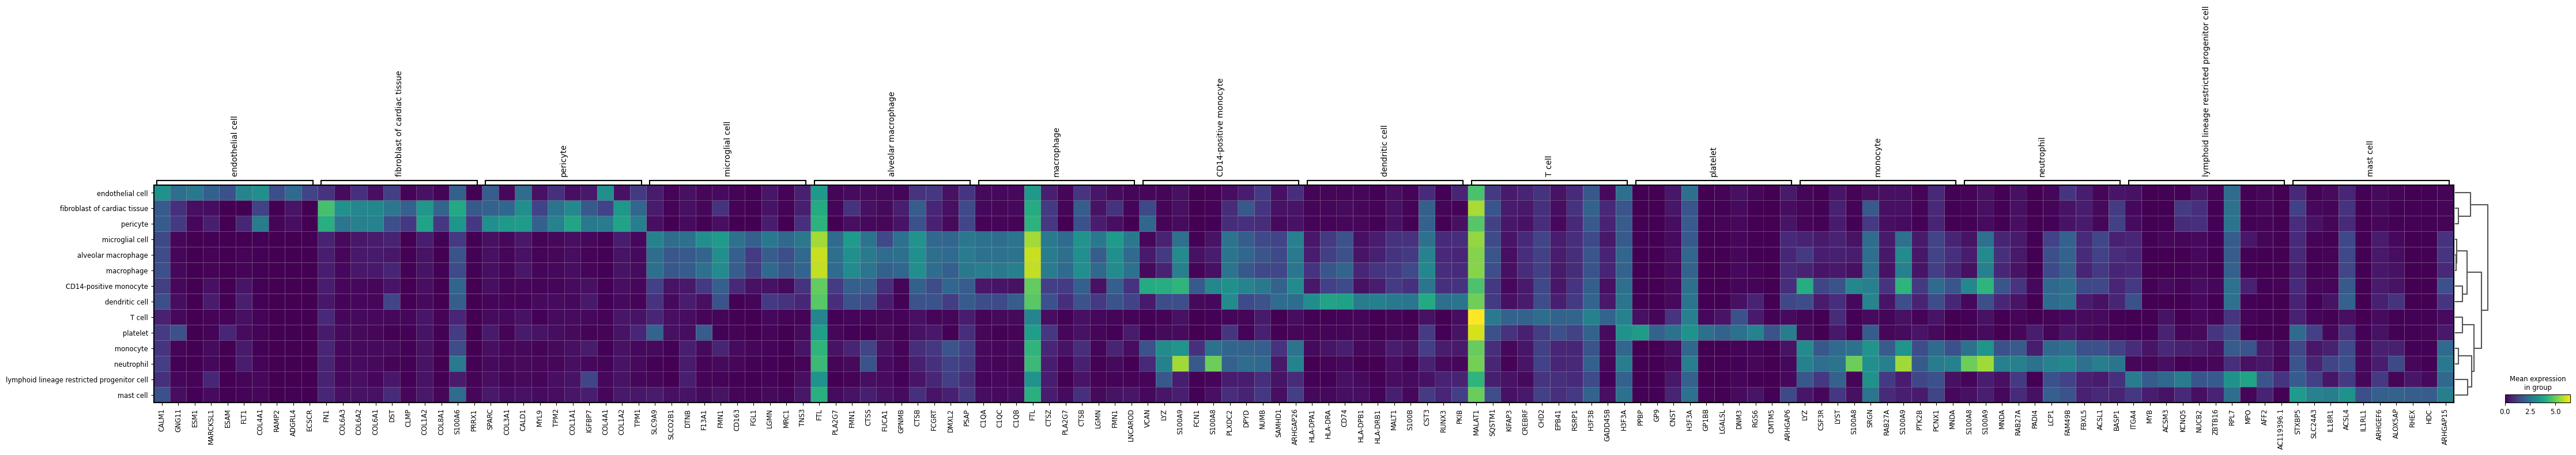

In [14]:
# | echo: false
# | warning: false

sc.pl.rank_genes_groups_matrixplot(adata)

# Pathway activity inference (Progeny)

3657 features of mat are empty, they will be removed.
Running mlm on mat with 31087 samples and 32944 targets for 14 sources.


  0%|          | 0/4 [00:00<?, ?it/s]

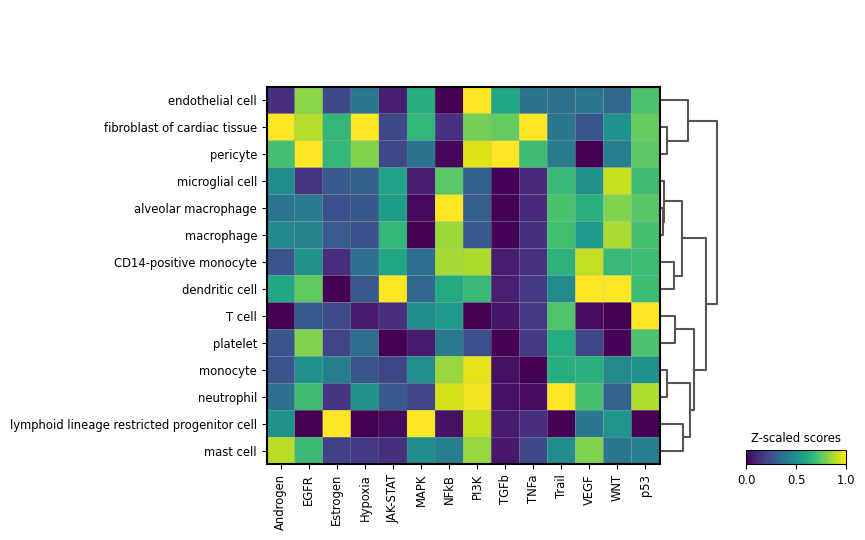

In [19]:
progeny = dc.get_progeny(organism=ORGANISM, top=500)
dc.run_mlm(
    mat=adata,
    net=progeny,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
    use_raw=False,
)

acts = dc.get_acts(adata, obsm_key="mlm_estimate")

sc.pl.matrixplot(
    acts,
    var_names=acts.var_names,
    groupby=CLUSTERING_COL,
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="viridis",
)

# Transcription Factor Activity Inference (CollecTRI)

3657 features of mat are empty, they will be removed.
Running ulm on mat with 31087 samples and 32944 targets for 763 sources.


  0%|          | 0/4 [00:00<?, ?it/s]

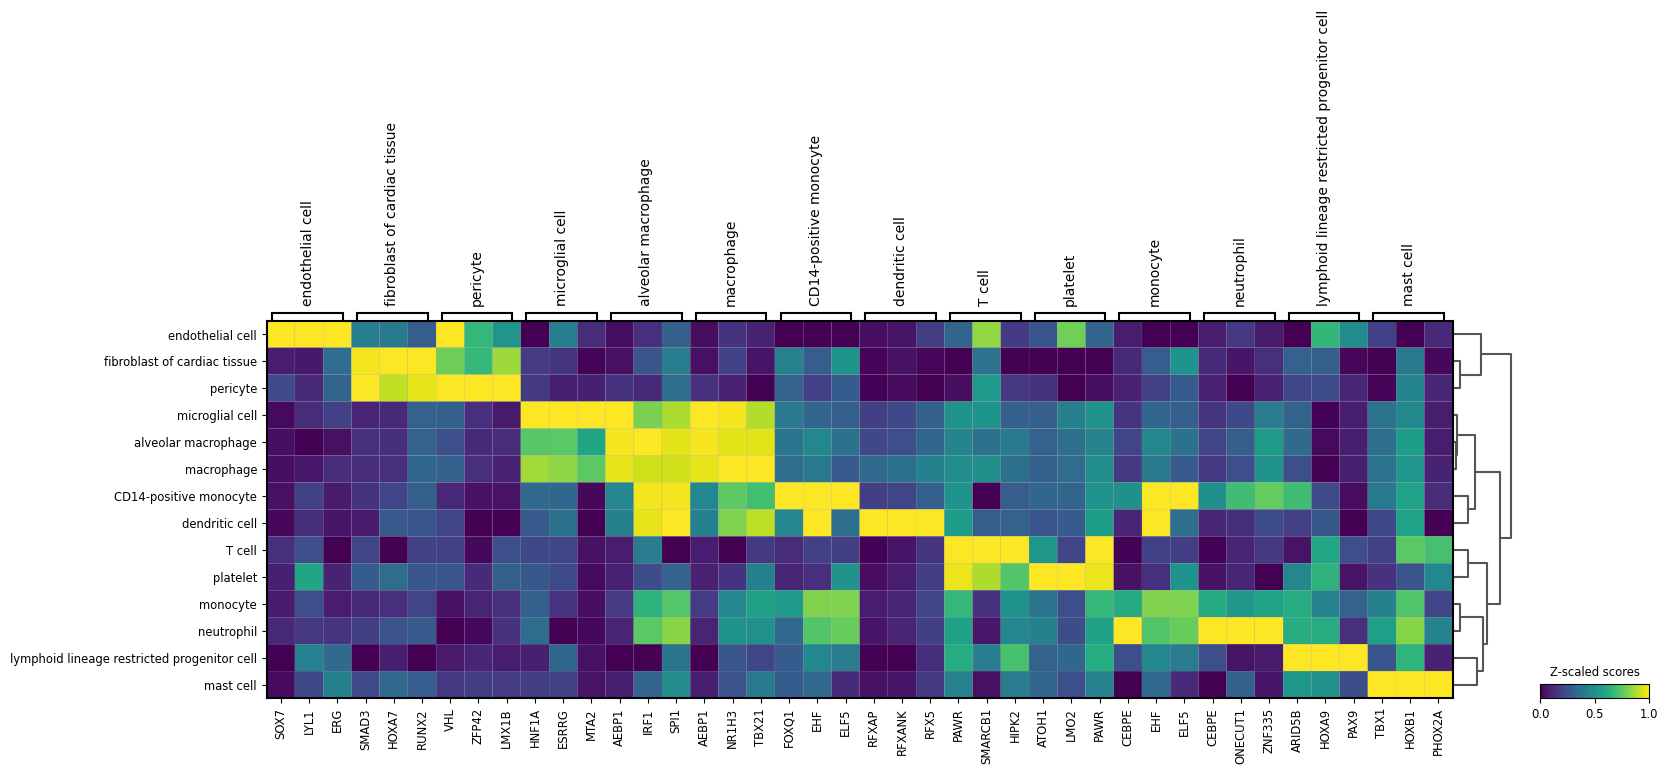

In [16]:
net = dc.get_collectri(organism=ORGANISM, split_complexes=False)

dc.run_ulm(
    mat=adata,
    net=net,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
    use_raw=False,
)

acts = dc.get_acts(adata, obsm_key="ulm_estimate")

df: pd.DataFrame = dc.rank_sources_groups(
    acts, groupby=CLUSTERING_COL, reference="rest", method="t-test_overestim_var"
)
n_markers = 3
source_markers: pd.DataFrame = (
    df.groupby("group")
    .head(n_markers)
    .groupby("group")["names"]
    .apply(lambda x: list(x))
    .to_dict()
)

sc.pl.matrixplot(
    acts,
    source_markers,
    CLUSTERING_COL,
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="viridis",
)


# AUCell 

In [17]:
import numpy as np
# TODO: The ORA method is very slow, check other implementations

msigdb = dc.get_resource("MSigDB")


go = msigdb[msigdb.collection == "go_biological_process"]
go = go[~go.duplicated(["geneset", "genesymbol"])]


In [18]:

dc.run_aucell(
    mat=adata,
    net=go,
    source="geneset",
    target="genesymbol",
    verbose=True,
    use_raw=False,
)

3657 features of mat are empty, they will be removed.


In [ ]:


acts = dc.get_acts(adata, obsm_key="ora_estimate")

acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e
df = dc.rank_sources_groups(
    acts, groupby=CLUSTERING_COL, reference="rest", method="t-test_overestim_var"
)

n_markers = 5
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .groupby("group")["names"]
    .apply(lambda x: list(x))
    .to_dict()
)

sc.pl.matrixplot(
    acts,
    source_markers,
    CLUSTERING_COL,
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="viridis",
)


# GSEA enrichment

In [41]:
gene_rank = sc.get.rank_genes_groups_df(adata, group=cell_types[0])[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)
# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(adata.var_names[adata.var.n_cells_by_counts>30])]

In [42]:
gene_set_names = gs.get_library_name(organism=ORGANISM)
res = gs.prerank(rnk=gene_rank, gene_sets='GO_Biological_Process_2023')

2024-09-04 21:44:24,440 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
gs.dotplot(res.res2d, column="FDR q-val", top_term = 15, figsize=(8,8), title=cell_types[0], size=5)